# Introduction
This notebook trains a number of algorithms for the Kaggle competition: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction. The goal of this competition is to find out whether a driver will make a claim or not. Due to the fact that the data is anonymized feature engineering is difficult. Therefore my solution focuses mainly on emsembling a variety of models using blending.

This notebook uses XGBoost, LightGBM, CatBoost and Regularized Greedy Forest. In another notebook a Field-Aware Factorization Machine is trained aswell. Due to the fact that Field-Aware Factoriztation Machines are very different from tree-based algorithms its features are engineered independently. At last 3 different public kernels are added to the ensemble.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc 
from multiprocessing import *
from sklearn.model_selection import StratifiedKFold, KFold

sns.set()

In [3]:
df_train = pd.read_csv('train.csv')
print('{} rows'.format(len(df_train)))
df_train.head()

595212 rows


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [4]:
df_test = pd.read_csv('test.csv')
print('{} rows'.format(len(df_test)))
df_test.head()

892816 rows


,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,...,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,...,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,...,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,...,4,0,0,4,0,1,1,0,0,1


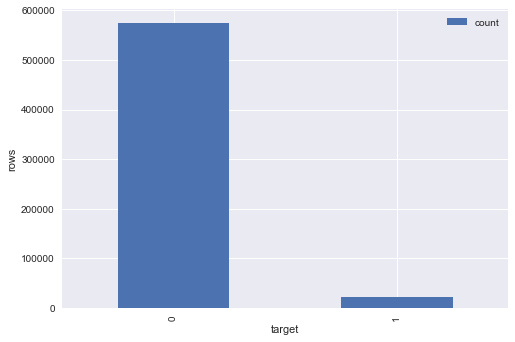

In [25]:
df_train[['target', 'id']].groupby('target').count().rename(columns = {'id': 'count'}).plot(kind = 'bar')
plt.ylabel('rows')
plt.show()

# Feature engineering

One hot encoding isn't necessary for tree-based algorithms so one hot encoded features are decoded.

In [5]:
def decode_ps_ind(x):
    if x.ps_ind_06_bin == 1:
        return 0
    elif x.ps_ind_07_bin == 1:
        return 1
    elif x.ps_ind_08_bin == 1:
        return 2
    elif x.ps_ind_09_bin == 1:
        return 3
    else:
        return -1
df_train['ps_ind_06-09'] = df_train[['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin']] \
                              .apply(decode_ps_ind, axis = 1)
df_test['ps_ind_06-09'] = df_test[['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin']] \
                             .apply(decode_ps_ind, axis = 1)

df_train.drop(['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin'], axis = 1)
df_test.drop(['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin'], axis = 1)

df_train.groupby('ps_ind_06-09')['ps_ind_06-09'].count()

ps_ind_06-09
0    234360
1    152989
2     97568
3    110295
Name: ps_ind_06-09, dtype: int64

In [6]:
df_train = df_train.replace(-1, np.NaN)
d_median = df_train.median(axis=0)
d_mean = df_train.mean(axis=0)
df_train = df_train.fillna(-1)
one_hot = {c: list(df_train[c].unique()) for c in df_train.columns if c not in ['id','target']}

def transform_df(df):
    df = pd.DataFrame(df)
    dcol = [c for c in df.columns if c not in ['id','target']]
    df['ps_car_13_x_ps_reg_03'] = df['ps_car_13'] * df['ps_reg_03']
    df['negative_one_vals'] = np.sum((df[dcol]==-1).values, axis=1)
    return df

def multi_transform(df):
    print('Init Shape: ', df.shape)
    p = Pool(cpu_count())
    df = p.map(transform_df, np.array_split(df, cpu_count()))
    df = pd.concat(df, axis=0, ignore_index=True).reset_index(drop=True)
    p.close(); p.join()
    print('After Shape: ', df.shape)
    return df

df_train = multi_transform(df_train)
df_test = multi_transform(df_test)

Init Shape:  (595212, 60)
After Shape:  (595212, 62)
Init Shape:  (892816, 59)
After Shape:  (892816, 61)


In [7]:
def add_features(df):
    best_features = ['ps_ind_03', 'ps_car_13', 'ps_reg_03', 'ps_ind_15']
    for i in range(len(best_features)):
        for j in range(i+1, len(best_features)):
            df[str(best_features[i]+'_times_'+best_features[j])] = df[best_features[i]] * df[best_features[j]]
    return df

df_train = add_features(df_train)
df_test = add_features(df_test)

## Feature correlations

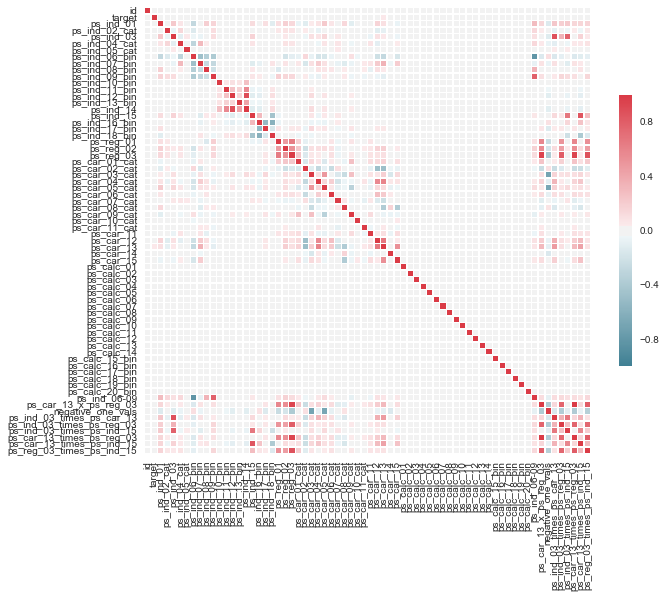

In [8]:
plt.figure(figsize = (10, 10))

corr = df_train.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

# Model training

In [9]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
 
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

In [10]:
dont_use = ['id', 'target'] + [c for c in df_train.columns if 'calc' in c] + ['ps_ind_11_bin', 'ps_ind_13_bin']
label = ['target']

#features = df_train.drop(dont_use, axis = 1).columns
features = df_train.drop(dont_use + [c for c in df_train.columns if 'times' in c], axis = 1).columns

print('{} features'.format(len(features)))

38 features


## LightGBMClassifier

In [ ]:
import lightgbm as lgb

cv_splits = 5

if False: # only for first use 
    df_preds_lgb = pd.DataFrame(df_test.copy()['id'])
    df_preds_train_lgb = pd.DataFrame(df_train.copy()['id'])

for i in range(11):
    kf = StratifiedKFold(n_splits = cv_splits, shuffle = True, random_state = 0+i)
    cv_scores = []
    
    preds_lgb = np.zeros(len(df_test))
    preds_tr_lgb = np.zeros(len(df_train))
    
    for train_index, test_index in kf.split(df_train[features], df_train[label].values.ravel()):

        X_train = df_train.iloc[train_index, :].loc[:, features]
        y_train = df_train.iloc[train_index, :][label].values.ravel()
        X_test = df_train.iloc[test_index, :].loc[:, features]
        y_test = df_train.iloc[test_index, :][label].values.ravel()

        # preparing data
        train_data = lgb.Dataset(X_train, label = y_train, free_raw_data=False)
        val_data = lgb.Dataset(X_test, label = y_test, free_raw_data=False)

        params_lgb = {'objective': 'binary', 'metric': 'AUC', 'boosting': 'gbdt', 'learning_rate': 0.002,
                    'verbose': 0, 'num_leaves': 63, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'bagging_seed': i,
                    'feature_fraction': 0.9, 'feature_fraction_seed': i, 'max_bin': 16, 'num_rounds': 10000,
                    'min_data_in_leaf': 128, 'seed': i, 'lambda_l1': 0, 'lambda_l2': 20}
        model_lgb = lgb.train(params_lgb, train_data, valid_sets=[val_data], verbose_eval = None, 
                              early_stopping_rounds = 250)

        preds_valid = model_lgb.predict(X_test)
        preds_tr_lgb[test_index] += preds_valid
        cv_scores.append(gini_normalized(y_test, preds_valid))
        preds_lgb += model_lgb.predict(df_test[features]) / cv_splits
        print('Score: {:0.4f}'.format(cv_scores[-1]))
    
    df_preds_lgb = pd.read_csv('Predictions/Base/lgb/test.csv')
    df_preds_lgb[str(i)] = preds_lgb
    df_preds_lgb.to_csv('Predictions/Base/lgb/test.csv', index = False)
    
    df_preds_train_lgb = pd.read_csv('Predictions/Base/lgb/train.csv')
    df_preds_train_lgb[str(i)] = preds_tr_lgb
    df_preds_train_lgb.to_csv('Predictions/Base/lgb/train.csv', index = False)
    
    print('CV Score: {:0.4f} +- {:0.4f}'.format(np.mean(cv_scores), np.std(cv_scores)))

## XGBoostClassifier

In [ ]:
import xgboost as xgb

cv_splits = 5

if False: #only for first use
    df_preds_xgb = pd.DataFrame(df_test.copy()['id'])
    df_preds_train_xgb = pd.DataFrame(df_train.copy()['id'])

for i in range(5, 6):
    kf = StratifiedKFold(n_splits = cv_splits, shuffle = True, random_state = 100+i)

    preds_xgb = np.zeros(len(df_test))
    preds_tr_xgb = np.zeros(len(df_train))
    
    cv_scores = []
    for train_index, test_index in kf.split(df_train[features], df_train[label].values.ravel()):

        X_train = df_train.iloc[train_index, :].loc[:, features]
        y_train = df_train.iloc[train_index, :][label].values.ravel()
        X_test = df_train.iloc[test_index, :].loc[:, features]
        y_test = df_train.iloc[test_index, :][label].values.ravel()

        # preparing data
        train_data = xgb.DMatrix(X_train, label = y_train)
        val_data = xgb.DMatrix(X_test, label = y_test)

        params_xgb = {'objective': 'binary:logistic', 'eval_metric': 'auc', 'eta': 0.005
                      'subsample': 0.8, 'colsample_bytree': 0.9, 'silent': True, 'max_depth': 3, 
                      'min_child_weight': 8, 'scale_pos_weight': 1, 'seed': i, 
                      'gamma': 1.1, 'reg_alpha': 11, 'reg_lambda': 1.0}
        watchlist = [(train_data, 'train'), (val_data, 'valid')]
        model_xgb = xgb.train(params_xgb, train_data, 25000, watchlist, verbose_eval = None, 
                              early_stopping_rounds = 250)

        preds_valid = model_xgb.predict(xgb.DMatrix(X_test))
        preds_tr_xgb[test_index] += preds_valid
        cv_scores.append(gini_normalized(y_test, preds_valid))
        preds_xgb += model_xgb.predict(xgb.DMatrix(df_test[features])) / cv_splits
        print('Score: {:0.4f}'.format(cv_scores[-1]))

    print('CV Score: {:0.4f} +- {:0.4f}'.format(np.mean(cv_scores), np.std(cv_scores)))

    df_preds_xgb = pd.read_csv('Predictions/Base/xgb/test.csv')
    df_preds_xgb[str(i)] = preds_xgb
    df_preds_xgb.to_csv('Predictions/Base/xgb/test.csv', index = False)
    
    df_preds_train_xgb = pd.read_csv('Predictions/Base/xgb/train.csv')
    df_preds_train_xgb[str(i)] = preds_tr_xgb
    df_preds_train_xgb.to_csv('Predictions/Base/xgb/train.csv', index = False)

## CatBoostClassifier

In [ ]:
from catboost import Pool, CatBoostClassifier

cv_splits = 5

if False: # only for first use
    df_preds_cat = pd.DataFrame(df_test.copy()['id'])
    df_preds_train_cat = pd.DataFrame(df_train.copy()['id'])

for i in range(5, 6):
    kf = StratifiedKFold(n_splits = cv_splits, shuffle = True, random_state = 200+i)
    
    preds_cat = np.zeros(len(df_test))
    preds_tr_cat = np.zeros(len(df_train))
    
    cv_scores = []
    
    for train_index, test_index in kf.split(df_train[features], df_train[label].values.ravel()):    
        X_train = df_train.iloc[train_index, :].loc[:, features]
        y_train = df_train.iloc[train_index, :][label].values.ravel()
        X_test = df_train.iloc[test_index, :].loc[:, features]
        y_test = df_train.iloc[test_index, :][label].values.ravel()

        # preparing data
        train_data = Pool(X_train, label = y_train)
        val_data = Pool(X_test, label = y_test)

        model_cat = CatBoostClassifier(iterations=4500, learning_rate=0.01, depth=6, verbose = False, #plot = True,
                                   l2_leaf_reg=14, rsm=1.0, loss_function='Logloss', border_count=128, thread_count=3,
                                   use_best_model=True, ctr_border_count=16, bagging_temperature=0.8,
                                   max_ctr_complexity=4, has_time=False, class_weights=None, eval_metric='AUC',
                                   random_seed = 200+i
                                  )
        model_cat.fit(train_data, eval_set = val_data, use_best_model = True)

        preds_valid = model_cat.predict_proba(Pool(X_test))[:, 1]
        preds_tr_cat[test_index] += preds_valid
        cv_scores.append(gini_normalized(y_test, preds_valid))
        preds_cat += model_cat.predict_proba(Pool(df_test[features]))[:, 1] / cv_splits
        print('Score: {:0.4f}'.format(cv_scores[-1]))

    print('CV Score: {:0.4f} +- {:0.4f}'.format(np.mean(cv_scores), np.std(cv_scores)))
    
    df_preds_cat = pd.read_csv('Predictions/Base/cat/test.csv')
    df_preds_cat[str(i)] = preds_cat
    df_preds_cat.to_csv('Predictions/Base/cat/test.csv', index = False)
    
    df_preds_train_cat = pd.read_csv('Predictions/Base/cat/train.csv')
    df_preds_train_cat[str(i)] = preds_tr_cat
    df_preds_train_cat.to_csv('Predictions/Base/cat/train.csv', index = False)

## Regularized Greedy Forest
rgf_python doesn't support multithreading so multiprocessing is used to run multiple models parallel

In [205]:
# Regularized Greedy Forest
from rgf.sklearn import RGFClassifier     # https://github.com/fukatani/rgf_python
import multiprocessing

cv_splits = 10 #5 for first 10

if False: # only for first use
    df_preds_rgf = pd.DataFrame(df_test.copy()['id'])
    df_preds_rgf.to_csv('Predictions/Base/rgf/test.csv', index = False)
    df_preds_train_rgf = pd.DataFrame(df_train.copy()['id'])
    df_preds_train_rgf.to_csv('Predictions/Base/rgf/train.csv', index = False)

def run_rgf_worker(seed):
    kf = StratifiedKFold(n_splits = cv_splits, shuffle = True, random_state = 300+seed)
    
    preds_rgf = np.zeros(len(df_test))
    preds_tr_rgf = np.zeros(len(df_train))
    
    cv_scores = []

    for train_index, test_index in kf.split(df_train[features], df_train[label].values.ravel()):
        X_train = df_train.iloc[train_index, :].loc[:, features]
        y_train = df_train.iloc[train_index, :][label].values.ravel()
        X_test = df_train.iloc[test_index, :].loc[:, features]
        y_test = df_train.iloc[test_index, :][label].values.ravel()

        model_rgf = RGFClassifier(max_leaf=10000, algorithm="RGF_Opt", test_interval=100,
                                  verbose=False, l2 = 0.01, sl2 = 0.0001, min_samples_leaf = 1,
                                  learning_rate = 0.2)
        model_rgf.fit(X_train, y_train)

        preds_valid = model_rgf.predict_proba(X_test)[:, 1]
        preds_tr_rgf[test_index] += preds_valid
        cv_scores.append(gini_normalized(y_test, preds_valid))
        preds_rgf += model_rgf.predict_proba(df_test[features])[:, 1] / cv_splits
        print('Score: {:0.4f}, seed: {}'.format(cv_scores[-1], seed))
        
    print('CV Score: {:0.4f} +- {:0.4f}, seed: {}'.format(np.mean(cv_scores), np.std(cv_scores), seed))
        
    df_preds_rgf = pd.read_csv('Predictions/Base/rgf/test.csv')
    df_preds_rgf[str(seed)] = preds_rgf
    df_preds_rgf.to_csv('Predictions/Base/rgf/test.csv', index = False)

    df_preds_train_rgf = pd.read_csv('Predictions/Base/rgf/train.csv')
    df_preds_train_rgf[str(seed)] = preds_tr_rgf
    df_preds_train_rgf.to_csv('Predictions/Base/rgf/train.csv', index = False)
    
for i in range(10, 12):
    if __name__ == '__main__':
        worker_rgf = multiprocessing.Process(target = run_rgf_worker, args = (i*2))
        worker_rgf.start()

Score: 0.2624, seed: 20
Score: 0.2706, seed: 22
Score: 0.2813, seed: 20
Score: 0.2768, seed: 22
Score: 0.3037, seed: 20
Score: 0.2765, seed: 22
Score: 0.2874, seed: 20
Score: 0.2543, seed: 22
Score: 0.2740, seed: 20
Score: 0.3129, seed: 22
Score: 0.2822, seed: 20
Score: 0.2981, seed: 22
Score: 0.2824, seed: 20
Score: 0.2990, seed: 22
Score: 0.2904, seed: 20
Score: 0.2591, seed: 22
Score: 0.2945, seed: 20
Score: 0.2725, seed: 20
CV Score: 0.2831 +- 0.0112, seed: 20
Score: 0.2877, seed: 22
Score: 0.2882, seed: 22
CV Score: 0.2823 +- 0.0175, seed: 22


# External kernels
External kernels are added for ensembling

## Forza Baseline
https://www.kaggle.com/the1owl/forza-baseline

In [13]:
import numpy as np
import pandas as pd
from sklearn import *
import xgboost as xgb
import lightgbm as lgb
from multiprocessing import *

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
col = [c for c in train.columns if c not in ['id','target']]
col = [c for c in col if not c.startswith('ps_calc_')]

train = train.replace(-1, np.NaN)
d_median = train.median(axis=0)
d_mean = train.mean(axis=0)
train = train.fillna(-1)
one_hot = {c: list(train[c].unique()) for c in train.columns if c not in ['id','target']}

def transform_df(df):
    df = pd.DataFrame(df)
    dcol = [c for c in df.columns if c not in ['id','target']]
    df['ps_car_13_x_ps_reg_03'] = df['ps_car_13'] * df['ps_reg_03']
    df['negative_one_vals'] = np.sum((df[dcol]==-1).values, axis=1)
    for c in dcol:
        if '_bin' not in c: #standard arithmetic
            df[c+str('_median_range')] = (df[c].values > d_median[c]).astype(np.int)
            df[c+str('_mean_range')] = (df[c].values > d_mean[c]).astype(np.int)
            #df[c+str('_sq')] = np.power(df[c].values,2).astype(np.float32)
            #df[c+str('_sqr')] = np.square(df[c].values).astype(np.float32)
            #df[c+str('_log')] = np.log(np.abs(df[c].values) + 1)
            #df[c+str('_exp')] = np.exp(df[c].values) - 1
    for c in one_hot:
        if len(one_hot[c])>2 and len(one_hot[c]) < 7:
            for val in one_hot[c]:
                df[c+'_oh_' + str(val)] = (df[c].values == val).astype(np.int)
    return df

def multi_transform(df):
    print('Init Shape: ', df.shape)
    p = Pool(cpu_count())
    df = p.map(transform_df, np.array_split(df, cpu_count()))
    df = pd.concat(df, axis=0, ignore_index=True).reset_index(drop=True)
    p.close(); p.join()
    print('After Shape: ', df.shape)
    return df

def gini(y, pred):
    fpr, tpr, thr = metrics.roc_curve(y, pred, pos_label=1)
    g = 2 * metrics.auc(fpr, tpr) -1
    return g

train = multi_transform(train)
test = multi_transform(test)

col = [c for c in train.columns if c not in ['id','target']]
col = [c for c in col if not c.startswith('ps_calc_')]

/Users/Pepe/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Pepe/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/Pepe/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  

Init Shape:  (595212, 59)
After Shape:  (595212, 186)
Init Shape:  (892816, 58)
After Shape:  (892816, 185)


In [138]:
#LightGBM
def gini_lgb(preds, dtrain):
    y = list(dtrain.get_label())
    score = gini(y, preds) / gini(y, y)
    return 'gini', score, True

cv_splits = 5

if False:
    df_preds_FB_lgb = pd.DataFrame(df_test.copy()['id'])
    df_preds_FB_lgb.to_csv('Predictions/Base/FB_lgb/test.csv', index = False)
    df_preds_train_FB_lgb = pd.DataFrame(df_train.copy()['id'])
    df_preds_train_FB_lgb.to_csv('Predictions/Base/FB_lgb/train.csv', index = False)

for i in range(1, 4):
    preds_FB_lgb = np.zeros(len(df_test))
    preds_tr_FB_lgb = np.zeros(len(df_train))

    kf = StratifiedKFold(n_splits = cv_splits, shuffle = True, random_state = 400+i)
    cv_scores = []

    for train_index, test_index in kf.split(train[col], train[label].values.ravel()):
        X_train = train.iloc[train_index, :].loc[:, col]
        y_train = train.iloc[train_index, :][label].values.ravel()
        X_test = train.iloc[test_index, :].loc[:, col]
        y_test = train.iloc[test_index, :][label].values.ravel()

        params = {'learning_rate': 0.002, 'max_depth': 4, 'boosting': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
                  'is_training_metric': False, 'seed': i}
        model2 = lgb.train(params, lgb.Dataset(X_train, label=y_train), 10000, lgb.Dataset(X_test, label=y_test), 
                           verbose_eval=None, feval=gini_lgb, early_stopping_rounds=250)

        preds_valid = model2.predict(X_test)
        preds_tr_FB_lgb[test_index] += preds_valid
        cv_scores.append(gini_normalized(y_test, preds_valid))
        preds_FB_lgb += model2.predict(test[col]) / cv_splits
        print('Score: {:0.4f}'.format(cv_scores[-1]))

    print('CV Score: {:0.4f} +- {:0.4f}'.format(np.mean(cv_scores), np.std(cv_scores)))
    df_preds_FB_lgb = pd.read_csv('Predictions/Base/FB_lgb/test.csv')
    df_preds_FB_lgb[str(i)] = preds_FB_lgb
    df_preds_FB_lgb.to_csv('Predictions/Base/FB_lgb/test.csv', index = False)

    df_preds_train_FB_lgb = pd.read_csv('Predictions/Base/FB_lgb/train.csv')
    df_preds_train_FB_lgb[str(i)] = preds_tr_FB_lgb
    df_preds_train_FB_lgb.to_csv('Predictions/Base/FB_lgb/train.csv', index = False)

Score: 0.2835
Score: 0.2887
Score: 0.2941
Score: 0.2689
Score: 0.2759
CV Score: 0.2822 +- 0.0090
Score: 0.2759
Score: 0.2868
Score: 0.3008
Score: 0.2853
Score: 0.2620
CV Score: 0.2822 +- 0.0128
Score: 0.2809
Score: 0.2860
Score: 0.2800
Score: 0.2846
Score: 0.2866
CV Score: 0.2836 +- 0.0027


In [19]:
#XGBoost
def gini_xgb(pred, y):
    y = y.get_label()
    return 'gini', gini(y, pred)

cv_splits = 10 #5 for first 4


if False:
    df_preds_FB_xgb = pd.DataFrame(df_test.copy()['id'])
    df_preds_FB_xgb.to_csv('Predictions/Base/FB_xgb/test.csv', index = False)
    df_preds_train_FB_xgb = pd.DataFrame(df_train.copy()['id'])
    df_preds_train_FB_xgb.to_csv('Predictions/Base/FB_xgb/train.csv', index = False)

for i in range(5, 7):
    preds_FB_xgb = np.zeros(len(df_test))
    preds_tr_FB_xgb = np.zeros(len(df_train))

    kf = StratifiedKFold(n_splits = cv_splits, shuffle = True, random_state = 500+i)
    cv_scores = []

    for train_index, test_index in kf.split(train[col], train[label].values.ravel()):

        X_train = train.iloc[train_index, :].loc[:, col]
        y_train = train.iloc[train_index, :][label].values.ravel()
        X_test = train.iloc[test_index, :].loc[:, col]
        y_test = train.iloc[test_index, :][label].values.ravel()

        params = {'eta': 0.01, #0.005, for first 4 
                  'max_depth': 4, 'subsample': 0.9, 'colsample_bytree': 0.9, 'objective': 'binary:logistic', 
                  'eval_metric': 'auc', 'seed': i, 'silent': True}
        watchlist = [(xgb.DMatrix(X_train, y_train), 'train'), (xgb.DMatrix(X_test, y_test), 'valid')]
        model1 = xgb.train(params, xgb.DMatrix(X_train, y_train), 20000,  watchlist, feval=gini_xgb, maximize=True, 
                           verbose_eval=None, early_stopping_rounds=200)

        preds_valid = model1.predict(xgb.DMatrix(X_test))
        preds_tr_FB_xgb[test_index] += preds_valid
        cv_scores.append(gini_normalized(y_test, preds_valid))
        preds_FB_xgb += model1.predict(xgb.DMatrix(test[col])) / cv_splits
        print('Score: {:0.4f}'.format(cv_scores[-1]))

    print('CV Score: {:0.4f} +- {:0.4f}'.format(np.mean(cv_scores), np.std(cv_scores)))
    
    df_preds_FB_xgb = pd.read_csv('Predictions/Base/FB_xgb/test.csv')
    df_preds_FB_xgb[str(i)] = preds_FB_xgb
    df_preds_FB_xgb.to_csv('Predictions/Base/FB_xgb/test.csv', index = False)

    df_preds_train_FB_xgb = pd.read_csv('Predictions/Base/FB_xgb/train.csv')
    df_preds_train_FB_xgb[str(i)] = preds_tr_FB_xgb
    df_preds_train_FB_xgb.to_csv('Predictions/Base/FB_xgb/train.csv', index = False)

Score: 0.3242
Score: 0.2916
Score: 0.2634
Score: 0.2931
Score: 0.2807
Score: 0.2871
Score: 0.2731
Score: 0.2910
Score: 0.2913
Score: 0.2656
CV Score: 0.2861 +- 0.0165
Score: 0.2841
Score: 0.2981
Score: 0.2899
Score: 0.2920
Score: 0.2960
Score: 0.2914
Score: 0.2688
Score: 0.2931
Score: 0.2822
Score: 0.2694
CV Score: 0.2865 +- 0.0098


# Keras
https://www.kaggle.com/tilii7/keras-averaging-runs-gini-early-stopping

In [193]:
from datetime import datetime
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

from keras.models import load_model, Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, Callback
from keras.wrappers.scikit_learn import KerasClassifier

In [194]:
class roc_auc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict_proba(self.x, verbose=0)
        roc = roc_auc_score(self.y, y_pred)
        logs['roc_auc'] = roc_auc_score(self.y, y_pred)
        logs['norm_gini'] = ( roc_auc_score(self.y, y_pred) * 2 ) - 1

        y_pred_val = self.model.predict_proba(self.x_val, verbose=0)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        logs['roc_auc_val'] = roc_auc_score(self.y_val, y_pred_val)
        logs['norm_gini_val'] = ( roc_auc_score(self.y_val, y_pred_val) * 2 ) - 1

        print('\rroc_auc: %s - roc_auc_val: %s - norm_gini: %s - norm_gini_val: %s' % (str(round(roc,5)),str(round(roc_val,5)),str(round((roc*2-1),5)),str(round((roc_val*2-1),5))), end=10*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [195]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod(
            (datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' %
              (thour, tmin, round(tsec, 2)))

def scale_data(X, scaler=None):
    if not scaler:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler

In [196]:
# train and test data path
DATA_TRAIN_PATH = 'train.csv'
DATA_TEST_PATH = 'test.csv'

def load_data(path_train=DATA_TRAIN_PATH, path_test=DATA_TEST_PATH):
    train_loader = pd.read_csv(path_train, dtype={'target': np.int8, 'id': np.int32})
    train = train_loader.drop(['target', 'id'], axis=1)
    train_labels = train_loader['target'].values
    train_ids = train_loader['id'].values
    print('\n Shape of raw train data:', train.shape)

    test_loader = pd.read_csv(path_test, dtype={'id': np.int32})
    test = test_loader.drop(['id'], axis=1)
    test_ids = test_loader['id'].values
    print(' Shape of raw test data:', test.shape)

    return train, train_labels, test, train_ids, test_ids

In [197]:
# Load data set and target values
train, target, test, tr_ids, te_ids = load_data()
n_train = train.shape[0]
train_test = pd.concat((train, test)).reset_index(drop=True)
col_to_drop = train.columns[train.columns.str.endswith('_cat')]
col_to_dummify = train.columns[train.columns.str.endswith('_cat')].astype(str).tolist()

for col in col_to_dummify:
    dummy = pd.get_dummies(train_test[col].astype('category'))
    columns = dummy.columns.astype(str).tolist()
    columns = [col + '_' + w for w in columns]
    dummy.columns = columns
    train_test = pd.concat((train_test, dummy), axis=1)

train_test.drop(col_to_dummify, axis=1, inplace=True)
train_test_scaled, scaler = scale_data(train_test)
train = train_test_scaled[:n_train, :]
test = train_test_scaled[n_train:, :]
print('\n Shape of processed train data:', train.shape)
print(' Shape of processed test data:', test.shape)


 Shape of raw train data: (595212, 57)
 Shape of raw test data: (892816, 57)

 Shape of processed train data: (595212, 227)
 Shape of processed test data: (892816, 227)


In [198]:
patience = 10
batchsize = 128

In [203]:
# Let's split the data into folds. I always use the same random number for reproducibility, 
# and suggest that you do the same (you certainly don't have to use 1001).

cv_splits = 5

if False:
    df_preds_keras = pd.DataFrame(df_test.copy()['id'])
    df_preds_keras.to_csv('Predictions/Base/keras/test.csv', index = False)
    df_preds_train_keras = pd.DataFrame(df_train.copy()['id'])
    df_preds_train_keras.to_csv('Predictions/Base/keras/train.csv', index = False)

starttime = timer(None)
for i in range(6, 7):
    skf = StratifiedKFold(n_splits=cv_splits, random_state=600+i)
    
    preds_keras = np.zeros(len(df_test))
    preds_tr_keras = np.zeros(len(df_train))
    cv_scores = []

    for j, (train_index, test_index) in enumerate(skf.split(train, target)):
        X_train, X_val = train[train_index], train[test_index]
        y_train, y_val = target[train_index], target[test_index]
        train_ids, val_ids = tr_ids[train_index], tr_ids[test_index]

        # This is where we define and compile the model. These parameters are not optimal, as they were chosen 
        # to get a notebook to complete in 60 minutes. Other than leaving BatchNormalization and last sigmoid 
        # activation alone, virtually everything else can be optimized: number of neurons, types of initializers, 
        # activation functions, dropout values. The same goes for the optimizer at the end.

        # This definition must be within the for loop or else it will continue training previous model
        def baseline_model():
            model = Sequential()
            model.add(Dense(200, input_dim=X_train.shape[1], kernel_initializer='glorot_normal',))
            model.add(Activation('relu'))
            model.add(BatchNormalization())
            model.add(Dropout(0.5))
            model.add(Dense(100, kernel_initializer='glorot_normal'))
            model.add(Activation('relu'))
            model.add(BatchNormalization())
            model.add(Dropout(0.25))
            model.add(Dense(50, kernel_initializer='glorot_normal'))
            model.add(Activation('relu'))
            model.add(BatchNormalization())
            model.add(Dropout(0.15))
            model.add(Dense(25, kernel_initializer='glorot_normal'))
            model.add(Activation('relu'))
            model.add(BatchNormalization())
            model.add(Dropout(0.1))
            model.add(Dense(1, activation='sigmoid'))

            # Compile model
            model.compile(optimizer='adam', metrics = ['accuracy'], loss='binary_crossentropy')

            return model
        np.random.seed()

    # Lots to unpack here.

    # The first callback prints out roc_auc and gini values at the end of each epoch. It must be listed 
    # before the EarlyStopping callback, which monitors gini values saved in the previous callback. Make 
    # sure to set the mode to "max" because the default value ("auto") will not handle gini properly 
    # (it will act as if the model is not improving even when roc/gini go up).

    # CSVLogger creates a record of all iterations. Not really needed but it doesn't hurt to have it.

    # ModelCheckpoint saves a model each time gini improves. Its mode also must be set to "max" for reasons 
    # explained above.

        callbacks = [
            roc_auc_callback(training_data=(X_train, y_train),validation_data=(X_val, y_val)),  # call this before EarlyStopping
            EarlyStopping(monitor='norm_gini_val', patience=patience, mode='max', verbose=1),
            CSVLogger('keras/keras-5fold-run-01-v1-epochs.log', separator=',', append=False),
            ModelCheckpoint(
                    'keras/keras-5fold-run-01-v1-fold-' + str('%02d' % (j + 1)) + '-run-' + str('%02d' % (i + 1)) + '.check',
                    monitor='norm_gini_val', mode='max', # mode must be set to max or Keras will be confused
                    save_best_only=True,
                    verbose=1)
        ]
        nnet = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=batchsize,
                               validation_data=(X_val, y_val), verbose=2, shuffle=True, callbacks=callbacks)

        fit = nnet.fit(X_train, y_train)

        # We want the best saved model - not the last one where the training stopped. So we delete the old 
        # model instance and load the model from the last saved checkpoint. Next we predict values both for 
        # validation and test data, and create a summary of parameters for each run.

        del nnet
        nnet = load_model('keras/keras-5fold-run-01-v1-fold-' + str('%02d' % (j + 1)) + '-run-' + str('%02d' % (i + 1)) + '.check')

        preds_valid = nnet.predict_proba(X_val, verbose=0).ravel()
        preds_tr_keras[test_index] += preds_valid
        cv_scores.append(gini_normalized(y_val, preds_valid))
        preds_keras += nnet.predict(test).ravel() / cv_splits
        print('Run {}, Fold {}, Score: {:0.4f}'.format(i, j, cv_scores[-1]))

    print('CV Score: {:0.4f} +- {:0.4f}'.format(np.mean(cv_scores), np.std(cv_scores)))
    
    df_preds_keras = pd.read_csv('Predictions/Base/keras/test.csv')
    df_preds_keras[str(i)] = preds_keras
    df_preds_keras.to_csv('Predictions/Base/keras/test.csv', index = False)

    df_preds_train_keras = pd.read_csv('Predictions/Base/keras/train.csv')
    df_preds_train_keras[str(i)] = preds_tr_keras
    df_preds_train_keras.to_csv('Predictions/Base/keras/train.csv', index = False)

Train on 476169 samples, validate on 119043 samples
Epoch 1/100
roc_auc: 0.61754 - roc_auc_val: 0.61333 - norm_gini: 0.23508 - norm_gini_val: 0.22665          
Epoch 00001: norm_gini_val improved from -inf to 0.22665, saving model to keras/keras-5fold-run-01-v1-fold-01-run-07.check
 - 141s - loss: 0.1826 - acc: 0.9532 - val_loss: 0.1537 - val_acc: 0.9636
Epoch 2/100
roc_auc: 0.63281 - roc_auc_val: 0.6249 - norm_gini: 0.26561 - norm_gini_val: 0.24979          
Epoch 00002: norm_gini_val improved from 0.22665 to 0.24979, saving model to keras/keras-5fold-run-01-v1-fold-01-run-07.check
 - 126s - loss: 0.1548 - acc: 0.9636 - val_loss: 0.1529 - val_acc: 0.9636
Epoch 3/100
roc_auc: 0.63524 - roc_auc_val: 0.62809 - norm_gini: 0.27048 - norm_gini_val: 0.25619          
Epoch 00003: norm_gini_val improved from 0.24979 to 0.25619, saving model to keras/keras-5fold-run-01-v1-fold-01-run-07.check
 - 127s - loss: 0.1538 - acc: 0.9636 - val_loss: 0.1528 - val_acc: 0.9636
Epoch 4/100
roc_auc: 0.6384 

Epoch 33/100
roc_auc: 0.66199 - roc_auc_val: 0.63491 - norm_gini: 0.32398 - norm_gini_val: 0.26983          
Epoch 00033: norm_gini_val did not improve
 - 125s - loss: 0.1517 - acc: 0.9636 - val_loss: 0.1523 - val_acc: 0.9636
Epoch 34/100
roc_auc: 0.66427 - roc_auc_val: 0.63478 - norm_gini: 0.32855 - norm_gini_val: 0.26956          
Epoch 00034: norm_gini_val did not improve
 - 125s - loss: 0.1516 - acc: 0.9636 - val_loss: 0.1523 - val_acc: 0.9636
Epoch 00034: early stopping
Run 6, Fold 0, Score: 0.2731
Train on 476169 samples, validate on 119043 samples
Epoch 1/100
roc_auc: 0.62779 - roc_auc_val: 0.61938 - norm_gini: 0.25557 - norm_gini_val: 0.23876          
Epoch 00001: norm_gini_val improved from -inf to 0.23876, saving model to keras/keras-5fold-run-01-v1-fold-02-run-07.check
 - 153s - loss: 0.1820 - acc: 0.9535 - val_loss: 0.1533 - val_acc: 0.9636
Epoch 2/100
roc_auc: 0.6323 - roc_auc_val: 0.62532 - norm_gini: 0.26461 - norm_gini_val: 0.25065          
Epoch 00002: norm_gini_val 

Epoch 8/100
roc_auc: 0.64448 - roc_auc_val: 0.63288 - norm_gini: 0.28897 - norm_gini_val: 0.26576          
Epoch 00008: norm_gini_val did not improve
 - 129s - loss: 0.1529 - acc: 0.9636 - val_loss: 0.1524 - val_acc: 0.9636
Epoch 9/100
roc_auc: 0.6452 - roc_auc_val: 0.63353 - norm_gini: 0.29039 - norm_gini_val: 0.26705          
Epoch 00009: norm_gini_val improved from 0.26685 to 0.26705, saving model to keras/keras-5fold-run-01-v1-fold-03-run-07.check
 - 131s - loss: 0.1528 - acc: 0.9636 - val_loss: 0.1525 - val_acc: 0.9636
Epoch 10/100
roc_auc: 0.64707 - roc_auc_val: 0.63428 - norm_gini: 0.29414 - norm_gini_val: 0.26855          
Epoch 00010: norm_gini_val improved from 0.26705 to 0.26855, saving model to keras/keras-5fold-run-01-v1-fold-03-run-07.check
 - 132s - loss: 0.1526 - acc: 0.9636 - val_loss: 0.1523 - val_acc: 0.9636
Epoch 11/100
roc_auc: 0.64758 - roc_auc_val: 0.63268 - norm_gini: 0.29516 - norm_gini_val: 0.26537          
Epoch 00011: norm_gini_val did not improve
 - 132s

Epoch 13/100
roc_auc: 0.65187 - roc_auc_val: 0.63231 - norm_gini: 0.30375 - norm_gini_val: 0.26463          
Epoch 00013: norm_gini_val did not improve
 - 133s - loss: 0.1523 - acc: 0.9636 - val_loss: 0.1525 - val_acc: 0.9636
Epoch 14/100
roc_auc: 0.65293 - roc_auc_val: 0.63287 - norm_gini: 0.30586 - norm_gini_val: 0.26573          
Epoch 00014: norm_gini_val did not improve
 - 133s - loss: 0.1523 - acc: 0.9636 - val_loss: 0.1525 - val_acc: 0.9636
Epoch 15/100
roc_auc: 0.65449 - roc_auc_val: 0.63394 - norm_gini: 0.30898 - norm_gini_val: 0.26787          
Epoch 00015: norm_gini_val improved from 0.26755 to 0.26787, saving model to keras/keras-5fold-run-01-v1-fold-04-run-07.check
 - 133s - loss: 0.1522 - acc: 0.9636 - val_loss: 0.1524 - val_acc: 0.9636
Epoch 16/100
roc_auc: 0.6559 - roc_auc_val: 0.6331 - norm_gini: 0.31181 - norm_gini_val: 0.2662          
Epoch 00016: norm_gini_val did not improve
 - 133s - loss: 0.1521 - acc: 0.9636 - val_loss: 0.1524 - val_acc: 0.9636
Epoch 17/100
roc

# RGF with 20 nonlinear features
https://www.kaggle.com/lscoelho/rgf-with-20-nonlinear-features/code

In [214]:
# Starter code for RGF implemented by Leandro dos Santos Coelho
# Source code modified based on RGF + Target Encoding + Upsampling, Bojan Tunguz, 
# https://www.kaggle.com/tunguz/rgf-target-encoding-0-282-on-lb , version 8

import numpy as np
import pandas as pd
from rgf.sklearn import RGFClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from numba import jit
import time
import gc
import subprocess
import glob

import time
start_time = time.time()
tcurrent   = start_time

np.random.seed(31143)  

# from CPMP's kernel https://www.kaggle.com/cpmpml/extremely-fast-gini-computation
@jit
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]

def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None,    # Revised to encode validation series
                  val_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior
    """
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_val_series = pd.merge(
        val_series.to_frame(val_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=val_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_val_series.index = val_series.index
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_val_series, noise_level), add_noise(ft_tst_series, noise_level)
    
# Read data
train_df = pd.read_csv('train.csv', na_values="-1") # .iloc[0:200,:]
test_df = pd.read_csv('test.csv', na_values="-1")

#---- begin FEATURE ENGINEERING: NONLINEAR feature engineering by Leandro dos Santos Coelho
# train
train_df['v001'] = train_df["ps_ind_03"]+train_df["ps_ind_14"]+np.square(train_df["ps_ind_15"])
train_df['v002'] = train_df["ps_ind_03"]+train_df["ps_ind_14"]+np.tanh(train_df["ps_ind_15"])
train_df['v003'] = train_df["ps_reg_01"]+train_df["ps_reg_02"]**3+train_df["ps_reg_03"]
train_df['v004'] = train_df["ps_reg_01"]**2.15+np.tanh(train_df["ps_reg_02"])+train_df["ps_reg_03"]**3.1
train_df['v005'] = train_df["ps_calc_01"]+train_df["ps_calc_13"]+np.tanh(train_df["ps_calc_14"])
train_df['v006'] = train_df["ps_car_13"]+np.tanh(train_df["v003"])
train_df['v007'] = train_df["ps_car_13"]+train_df["v002"]**2.7
train_df['v008'] = train_df["ps_car_13"]+train_df["v003"]**3.4
train_df['v009'] = train_df["ps_car_13"]+train_df["v004"]**3.1
train_df['v010'] = train_df["ps_car_13"]+train_df["v005"]**2.3

train_df['v011'] = train_df["ps_ind_03"]**2.1+train_df["ps_ind_14"]**0.45+train_df["ps_ind_15"]**2.4
train_df['v012'] = train_df["ps_ind_03"]**2.56+train_df["ps_calc_13"]**2.15+train_df["ps_reg_01"]**2.3
train_df['v013'] = train_df["v003"]**2.15+train_df["ps_reg_01"]**2.49+train_df["ps_ind_15"]**2.14
train_df['v014'] = train_df["v009"]**2.36+train_df["ps_calc_01"]**2.25+train_df["ps_reg_01"]**2.36
train_df['v015'] = train_df["v003"]**3.21+0.001*np.tanh(train_df["ps_reg_01"])+train_df["ps_ind_15"]**3.12
train_df['v016'] = train_df["v009"]**2.13+0.001*np.tanh(train_df["ps_calc_01"])+train_df["ps_reg_01"]**2.13
train_df['v017'] = train_df["v016"]**2+train_df["v001"]**2.1+train_df["v003"]**2.3

train_df['v018'] = train_df["v012"]**2.3+train_df["v002"]**2.3+train_df["v005"]**2.31
train_df['v019'] = train_df["v008"]**2.6+train_df["v009"]**2.1+train_df["v004"]**2.13
train_df['v020'] = train_df["v012"]**2.7+train_df["v002"]**2.2+train_df["v005"]**2.43

# test
test_df['v001'] = test_df["ps_ind_03"]+test_df["ps_ind_14"]+np.square(test_df["ps_ind_15"])
test_df['v002'] = test_df["ps_ind_03"]+test_df["ps_ind_14"]+np.tanh(test_df["ps_ind_15"])
test_df['v003'] = test_df["ps_reg_01"]+test_df["ps_reg_02"]**3+test_df["ps_reg_03"]
test_df['v004'] = test_df["ps_reg_01"]**2.15+np.tanh(test_df["ps_reg_02"])+test_df["ps_reg_03"]**3.1
test_df['v005'] = test_df["ps_calc_01"]+test_df["ps_calc_13"]+np.tanh(test_df["ps_calc_14"])
test_df['v006'] = test_df["ps_car_13"]+np.tanh(test_df["v003"])
test_df['v007'] = test_df["ps_car_13"]+test_df["v002"]**2.7
test_df['v008'] = test_df["ps_car_13"]+test_df["v003"]**3.4
test_df['v009'] = test_df["ps_car_13"]+test_df["v004"]**3.1
test_df['v010'] = test_df["ps_car_13"]+test_df["v005"]**2.3

test_df['v011'] = test_df["ps_ind_03"]**2.1+test_df["ps_ind_14"]**0.45+test_df["ps_ind_15"]**2.4
test_df['v012'] = test_df["ps_ind_03"]**2.56+test_df["ps_calc_13"]**2.15+test_df["ps_reg_01"]**2.3
test_df['v013'] = test_df["v003"]**2.15+test_df["ps_reg_01"]**2.49+test_df["ps_ind_15"]**2.14
test_df['v014'] = test_df["v009"]**2.36+test_df["ps_calc_01"]**2.25+test_df["ps_reg_01"]**2.36
test_df['v015'] = test_df["v003"]**3.21+0.001*np.tanh(test_df["ps_reg_01"])+test_df["ps_ind_15"]**3.12
test_df['v016'] = test_df["v009"]**2.13+0.001*np.tanh(test_df["ps_calc_01"])+test_df["ps_reg_01"]**2.13
test_df['v017'] = test_df["v016"]**2+test_df["v001"]**2.1+test_df["v003"]**2.3

test_df['v018'] = test_df["v012"]**2.3+test_df["v002"]**2.3+test_df["v005"]**2.31
test_df['v019'] = test_df["v008"]**2.6+test_df["v009"]**2.1+test_df["v004"]**2.13
test_df['v020'] = test_df["v012"]**2.7+test_df["v002"]**2.2+test_df["v005"]**2.43

#---- end FEATURE ENGINEERING: NONLINEAR feature engineering by Leandro dos Santos Coelho

# from olivier
train_features = [
    "ps_car_13",  #            : 1571.65 / shadow  609.23
	"ps_reg_03",  #            : 1408.42 / shadow  511.15
	"ps_ind_05_cat",  #        : 1387.87 / shadow   84.72
	"ps_ind_03",  #            : 1219.47 / shadow  230.55
	"ps_ind_15",  #            :  922.18 / shadow  242.00
	"ps_reg_02",  #            :  920.65 / shadow  267.50
	"ps_car_14",  #            :  798.48 / shadow  549.58
	"ps_car_12",  #            :  731.93 / shadow  293.62
	"ps_car_01_cat",  #        :  698.07 / shadow  178.72
	"ps_car_07_cat",  #        :  694.53 / shadow   36.35
	"ps_ind_17_bin",  #        :  620.77 / shadow   23.15
	"ps_car_03_cat",  #        :  611.73 / shadow   50.67
	"ps_reg_01",  #            :  598.60 / shadow  178.57
	"ps_car_15",  #            :  593.35 / shadow  226.43
	"ps_ind_01",  #            :  547.32 / shadow  154.58
	"ps_ind_16_bin",  #        :  475.37 / shadow   34.17
	"ps_ind_07_bin",  #        :  435.28 / shadow   28.92
	"ps_car_06_cat",  #        :  398.02 / shadow  212.43
	"ps_car_04_cat",  #        :  376.87 / shadow   76.98
	"ps_ind_06_bin",  #        :  370.97 / shadow   36.13
	"ps_car_09_cat",  #        :  214.12 / shadow   81.38
	"ps_car_02_cat",  #        :  203.03 / shadow   26.67
	"ps_ind_02_cat",  #        :  189.47 / shadow   65.68
	"ps_car_11",  #            :  173.28 / shadow   76.45
	"ps_car_05_cat",  #        :  172.75 / shadow   62.92
	"ps_calc_09",  #           :  169.13 / shadow  129.72
	"ps_calc_05",  #           :  148.83 / shadow  120.68
	"ps_ind_08_bin",  #        :  140.73 / shadow   27.63
	"ps_car_08_cat",  #        :  120.87 / shadow   28.82
	"ps_ind_09_bin",  #        :  113.92 / shadow   27.05
	"ps_ind_04_cat",  #        :  107.27 / shadow   37.43
	"ps_ind_18_bin",  #        :   77.42 / shadow   25.97
	"ps_ind_12_bin",  #        :   39.67 / shadow   15.52
	"ps_ind_14",  #            :   37.37 / shadow   16.65
	
	"v001","v002","v003","v004","v005",
	"v006","v007","v008","v009","v010",   
	"v011","v012","v013","v014","v015",   
	"v016","v017","v018","v019","v020", # new nonlinear features
]

# add combinations
combs = [
    ('ps_reg_01', 'ps_car_02_cat'),  
    ('ps_reg_01', 'ps_car_04_cat'),
]

# Process data
id_test = test_df['id'].values
id_train = train_df['id'].values
y = train_df['target']

start = time.time()
for n_c, (f1, f2) in enumerate(combs):
    name1 = f1 + "_plus_" + f2
    print('current feature %60s %4d in %5.1f'
          % (name1, n_c + 1, (time.time() - start) / 60), end='')
    print('\r' * 75, end='')
    train_df[name1] = train_df[f1].apply(lambda x: str(x)) + "_" + train_df[f2].apply(lambda x: str(x))
    test_df[name1] = test_df[f1].apply(lambda x: str(x)) + "_" + test_df[f2].apply(lambda x: str(x))
    # Label Encode
    lbl = LabelEncoder()
    lbl.fit(list(train_df[name1].values) + list(test_df[name1].values))
    train_df[name1] = lbl.transform(list(train_df[name1].values))
    test_df[name1] = lbl.transform(list(test_df[name1].values))

    train_features.append(name1)
    
X = train_df[train_features]
test_df = test_df[train_features]

f_cats = [f for f in X.columns if "_cat" in f]


y_valid_pred = 0*y
y_test_pred = 0

np.random.seed(11)

    
# Run CV

def run_rgf():
    model = RGFClassifier(
        max_leaf         = 1000,  # original code with 1000 (verify the time limit to run it in Kaggle environment)
        algorithm        = "RGF",  
        loss             = "Log",
        l2               = 0.011,
        sl2              = 0.011,
        normalize        = False,
        min_samples_leaf = 8,   # 10,
        n_iter           = None,
        opt_interval     = 100,
        learning_rate    = .4,  # .3,
        calc_prob        = "sigmoid",
        n_jobs           = -1,
        memory_policy    = "generous",
        verbose          = 0
    )
    
    fit_model = model.fit( X_train, y_train )
    pred      = fit_model.predict_proba(X_valid)[:,1]
    pred_test = fit_model.predict_proba(X_test)[:,1]
    
    try:
        subprocess.call('rm -rf /tmp/rgf/*', shell=True)
    except Exception as e:
        print(str(e))
    
    return pred, pred_test
    
if False:
    df_preds_rgf20 = pd.DataFrame(df_test.copy()['id'])
    df_preds_rgf20.to_csv('Predictions/Base/rgf20/test.csv', index = False)
    df_preds_train_rgf20 = pd.DataFrame(df_train.copy()['id'])
    df_preds_train_rgf20.to_csv('Predictions/Base/rgf20/train.csv', index = False)
    
for run in range(7, 8):
    # Set up folds
    K = 10 # 5 for first 7
    kf = KFold(n_splits = K, random_state = 700+run, shuffle = True)
    cv_scores = []
    
    preds_rgf20 = np.zeros(len(test_df))
    preds_tr_rgf20 = np.zeros(len(train_df))
    
    for i, (train_index, test_index) in enumerate(kf.split(train_df)):

        # Create data for this fold
        y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
        X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()
        X_test = test_df.copy()

        # Enocode data
        for f in f_cats:
            X_train[f + "_avg"], X_valid[f + "_avg"], X_test[f + "_avg"] = target_encode(
                                                            trn_series=X_train[f],
                                                            val_series=X_valid[f],
                                                            tst_series=X_test[f],
                                                            target=y_train,
                                                            min_samples_leaf=200,
                                                            smoothing=10,
                                                            noise_level=0
                                                            )
        # Run model for this fold
        X_train = X_train.fillna(X_train.mean())
        X_valid = X_valid.fillna(X_valid.mean())
        X_test  = X_test.fillna(X_test.mean())

        # Generate validation predictions for this fold
        preds_valid, pred_test = run_rgf()
        
        preds_tr_rgf20[test_index] += preds_valid
        cv_scores.append(gini_normalized(y_valid, preds_valid))
        preds_rgf20 += pred_test / K
        print(' ')
        print('Run {}, Fold {}, Score: {:0.4f}'.format(run, i, cv_scores[-1]))

        del X_test, X_train, X_valid, y_train

        gc.collect()
        gc.collect()
        gc.collect()
    
    print('CV Score: {:0.4f} +- {:0.4f}'.format(np.mean(cv_scores), np.std(cv_scores)))
    
    df_preds_rgf20 = pd.read_csv('Predictions/Base/rgf20/test.csv')
    df_preds_rgf20[str(run)] = preds_rgf20
    df_preds_rgf20.to_csv('Predictions/Base/rgf20/test.csv', index = False)

    df_preds_train_rgf20 = pd.read_csv('Predictions/Base/rgf20/train.csv')
    df_preds_train_rgf20[str(run)] = preds_tr_rgf20
    df_preds_train_rgf20.to_csv('Predictions/Base/rgf20/train.csv', index = False)

    print( "\nFinished ...")
    nm=(time.time() - start_time)/60
    print ("Total time %s min" % nm)
    print('-------------')


current feature                                 ps_reg_01_plus_ps_car_04_cat    2 in   0.1 
Run 7, Fold 4, Score: 0.2915
 
Run 7, Fold 4, Score: 0.2708
 
Run 7, Fold 4, Score: 0.2807
 
Run 7, Fold 4, Score: 0.2650
 
Run 7, Fold 4, Score: 0.3126
 
Run 7, Fold 4, Score: 0.3022
 
Run 7, Fold 4, Score: 0.2504
 
Run 7, Fold 4, Score: 0.2915
 
Run 7, Fold 4, Score: 0.2857
 
Run 7, Fold 4, Score: 0.2800
CV Score: 0.2831 +- 0.0172

Finished ...
Total time 360.4914371172587 min
-------------
